# Postprocess Delta Analysis

We will now look at the output of Delta. For package info, please refer to the Project2A Notebook.

You can also find a lot of extra info in the Delta documentation [here](https://delta.readthedocs.io/en/latest/usage/analysis.html)

In [3]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%gui qt

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
matplotlib.rc("figure", figsize=(10,5))

import seaborn as sns

import pathlib
import tifffile
import pickle

from skimage.measure import regionprops

import napari
from napari.utils.notebook_display import nbscreenshot

import delta

## Setup Folders
As always we start with specifying the data paths:

In [4]:
proj_dir = pathlib.Path(pathlib.Path.home(), 'I2ICourse', 'Project2B')
processed_dir = proj_dir / 'ProcessedData'
image_dir = proj_dir / 'RawData'

In [5]:
def to_str(posixpath):
    return str(posixpath.resolve())    

## Load Data
We can now load the data again. See [here](https://delta.readthedocs.io/en/latest/usage/analysis.html) for detailed instructions.
To load all data we can use the following command:

In [6]:
delta.config.load_config(to_str(proj_dir / 'config_2D_local.json'))
reader = delta.utilities.xpreader(image_dir)
processor = delta.pipeline.Pipeline(reader, reload=True, resfolder=to_str(processed_dir))

Loading configuration from: /Users/simonvanvliet/I2ICourse/Project2B/config_2D_local.json


We can the access the position of choice as:

In [7]:
pos = processor.positions[0]

Instead we can also just directly load a single position:

In [8]:
#find all position .pkl outputs:
file_dirs = sorted(processed_dir.glob('*.pkl'))
print(file_dirs)
# this loads the processed data
pos_name = to_str(file_dirs[0])
pos = delta.pipeline.Position(None,None,None)
pos.load(pos_name)

[PosixPath('/Users/simonvanvliet/I2ICourse/Project2B/ProcessedData/Position000000.pkl')]


## Visualize Segmentation with Napari

We can add the image data and segmentation data to Napari to visually inspect them:

In [9]:
imstack = np.stack(pos.rois[0].img_stack, axis=0) #load image data from position file
labelstack = np.stack(pos.rois[0].label_stack, axis=0) #load label data from position file

viewer = napari.view_image(imstack)
viewer.add_labels(labelstack)
viewer.show()

## Cell Tracking Data

All tracking info is stored in the [lineage object](https://delta.readthedocs.io/en/latest/usage/utils_desc.html#lineage). 

> **Exercise** 
> 
> Have a look the lineage class documentation and check what kind of information is stored

We can also use the `keys` method to see what information is stored in the lineage object:

In [10]:
lin = pos.rois[0].lineage #get lineage for first region of interest (whole frame)
cell_0 = lin.cells[0] #lineage info of first cell
print('info stored in linegae object =', cell_0.keys()) 


info stored in linegae object = dict_keys(['id', 'mother', 'frames', 'daughters', 'new_pole', 'old_pole', 'edges', 'length', 'width', 'area', 'perimeter'])


Next we will plot the length of the cells present in the first frame

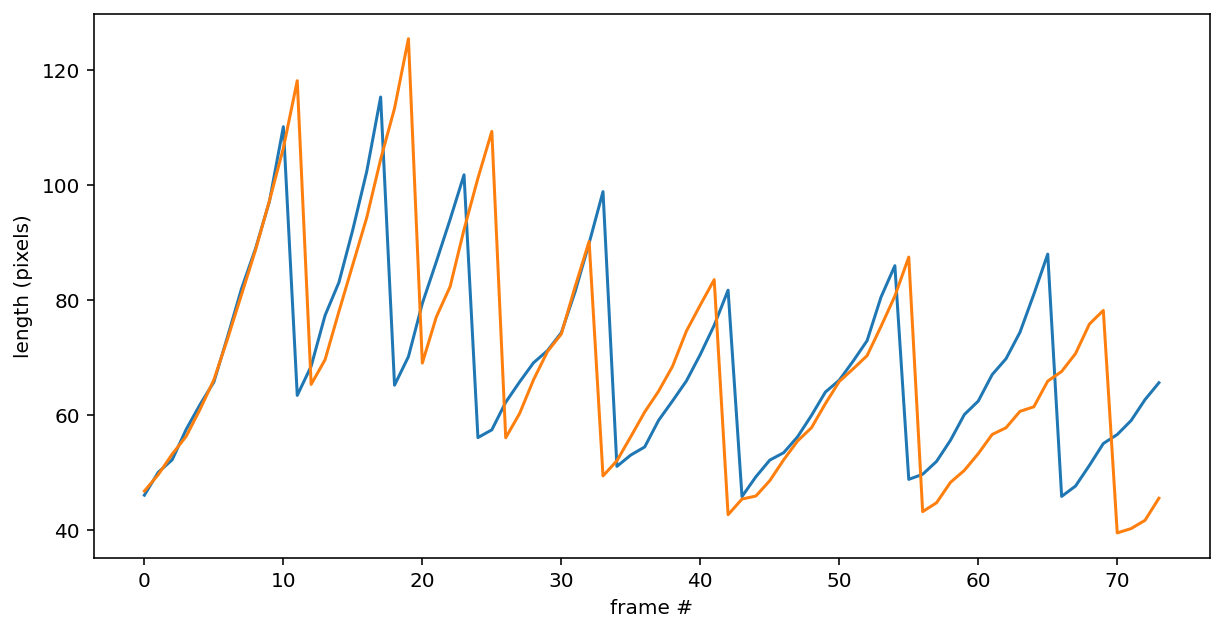

In [11]:
first_cells = lin.cellnumbers[0]
for cell_id in first_cells:
    cell = lin.cells[cell_id]
    plt.plot(cell['frames'],cell['length'])
plt.xlabel('frame #')
plt.ylabel('length (pixels)')
plt.show()    

## Convert Tracking Data to Standard Format

As you can clearly see from the saw-tooth pattern of cell length, a cell lineage in Delta is defined in a bit of a weird way as it continues across cell divisions. More commonly a cell lineage is defined to start at cell birth and stop and cell division. 

As a first step we thus have to split these lineages into segments.
Below we give a function that does this (no need to try to understand this code for now).

In [12]:
def split_lineages(lin):
    #first we give each sublineage a unique id
    unique_count = 0 
    #loop delta lineages
    for cell in lin.cells:

        ## create sublineage ID
        #find division events
        div_event = np.array([d is not None for d in cell['daughters']])
        #cumulative number of divisions gives a unique nr to each segment
        sublin_id = np.cumsum(div_event) 
        #now assign unique number accross all cell lineages
        unique_id = sublin_id + unique_count #unique cells id
        
        #update unique_count 
        unique_count += (np.sum(div_event) + 1)
        
        #init output fields
        empty_list = np.full_like(sublin_id, -1).tolist()
        cell['lin_id'] = empty_list
        cell['sublin_idx'] = empty_list
        cell['mother_lin_id'] = empty_list
        cell['d1_lin_id'] = empty_list
        cell['d2_lin_id'] = empty_list
        
        ##now we have to connect lineages together
        #find mother cell and birth frame
        mom_idx = cell['mother'] #this is mother of delta lineage 
        birth_frm = cell['frames'][0]        
        if mom_idx is not None:
            mom = lin.cells[mom_idx] #get properties of mom
            
            try:
                ## find unique cell id of the proper sub-segment in the mom lineage
                div_frm = mom['frames'].index(birth_frm-1)
                mom_lin_id = mom['lin_id'][div_frm] #this is proper unique lin id of mom
                
                ## we now want to add info of this d2 offspring to mother
                #we extract frames of current segment in mom (between current and prev division)
                div_events_mom = np.nonzero(np.array(mom['daughters'])[0:birth_frm])[0]
                start_idx = div_events_mom[-1] if div_events_mom.size > 0 else 0
                
                #assign d2 lin number to correct frames
                d2_temp = np.array(mom['d2_lin_id'])
                d2_temp[start_idx:birth_frm] = unique_count                
                mom['d2_lin_id'] = d2_temp.tolist()
                
            except:
                mom_lin_id = -1
        else:
            #no mom found (first cell)
             mom_lin_id = -1   
                    
        
        ## add mother info
        #the id of mother is the id of prev segment
        mother_lin_id = unique_id.copy() - 1
        #except for first segment, there we use the lin_index of mother we found above
        mother_lin_id[sublin_id==0] = mom_lin_id
        
        #add d1 offspring number to linage 
        #this is simply next segment
        d1_lin_id = unique_id.copy() + 1
        #except for last segment, this does not have d1 offspring 
        d1_lin_id[d1_lin_id==d1_lin_id[-1]] = -1

        #now we assign properties to cell
        cell['sublin_idx'] = sublin_id.tolist()
        cell['lin_id'] = unique_id.tolist()
        cell['mother_lin_id'] = mother_lin_id.tolist()
        cell['d1_lin_id'] = d1_lin_id.tolist()
        
    return None #lin is updated in place

We know apply this function, and can see we have added some new items to the linage object.

Most importantly: the property `lin_id` now gives a unique number to each and every cell.

In [13]:
split_lineages(lin) #call split lin function
print('info stored in linegae object =', lin.cells[0].keys()) 

info stored in linegae object = dict_keys(['id', 'mother', 'frames', 'daughters', 'new_pole', 'old_pole', 'edges', 'length', 'width', 'area', 'perimeter', 'lin_id', 'sublin_idx', 'mother_lin_id', 'd1_lin_id', 'd2_lin_id'])


We can use this plot each lineage separately:

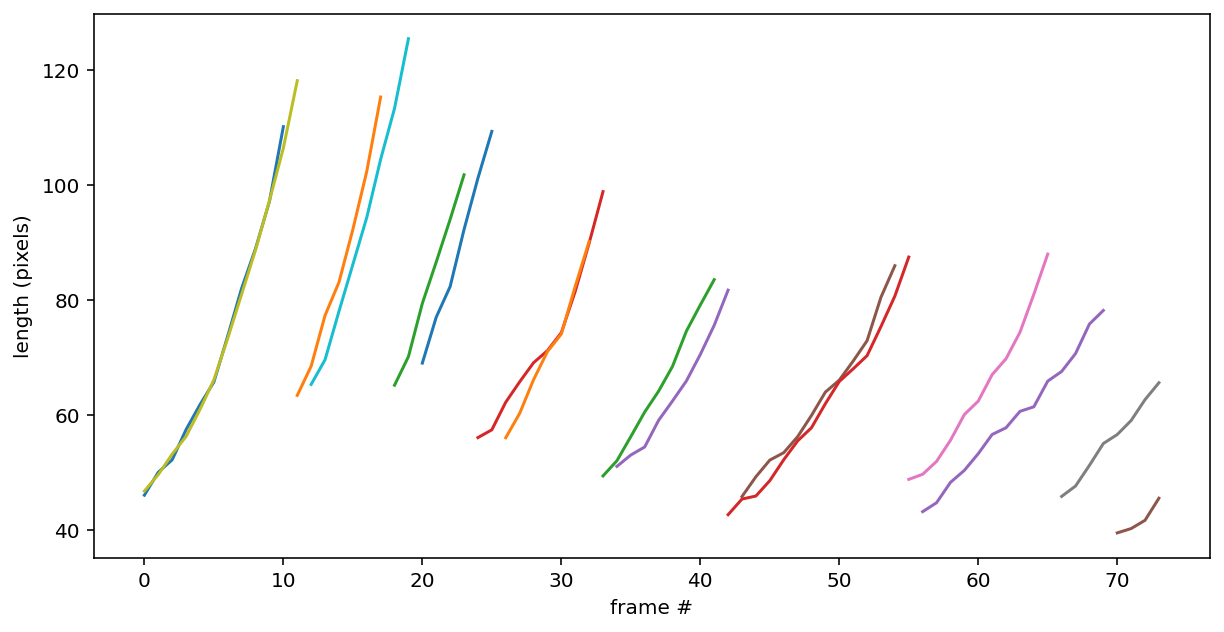

In [15]:
first_cells = lin.cellnumbers[0]
for cell_id in first_cells:
    #current cell lineage
    cell = lin.cells[cell_id]
    
    #convert lists to numpy arrays for easier manipulation
    lin_id_vec = np.array(cell['lin_id'])
    lin_frames = np.array(cell['frames'])
    lin_length = np.array(cell['length'])
    
    #loop over all sublineages 
    for lin_id in np.unique(lin_id_vec):
        #find frames of current sub-lin
        curr_frames = lin_id_vec==lin_id
        plt.plot(lin_frames[curr_frames],lin_length[curr_frames])
plt.xlabel('frame #')
plt.ylabel('length (pixels)')
plt.show()   

## Add Positional Information

If you have another look at the lineage object you can see it does not contain information on the location of cells. We add a function below to do this.

In [16]:
def add_segment_info(lin, label_stack):  
    
    #use region properties to get cell properties 
    rp = [regionprops(label_im) for label_im in label_stack]
    
    #there is an annoying miss-match between the indexing of rp and the label image
    #here we make a look-up-table to connect the two
    label_lut = []
    for cell_nr in lin.cellnumbers:
        cell_nr = cell_nr.copy()
        cell_nr.sort() #list of cell numbers in label image
        label_lut.append(cell_nr) #list of list

    for idx, cell in enumerate(lin.cells):        
        cell_idx = cell['id'] #the number cell has in label image
        cell_frames = cell['frames'] #the frame the cell exists
        
        #init output        
        x_pos = np.full(len(cell_frames), np.nan)
        y_pos = np.full(len(cell_frames), np.nan)
        
        for f_idx, frame in enumerate(cell_frames):
            rp_idx = label_lut[frame].index(cell_idx) #index in rp
            centroid = rp[frame][rp_idx].centroid #cell centroid
            
            if len(centroid) == 2:
                x_pos[f_idx] = centroid[1]
                y_pos[f_idx] = centroid[0]
                
        lin.cells[idx]['x_pos'] = x_pos.tolist()
        lin.cells[idx]['y_pos'] = y_pos.tolist()
        
    return None

We know apply this function, and can see we have added some new items to the linage object:

In [23]:
add_segment_info(lin, pos.rois[0].label_stack) #call split lin function
print('info stored in linegae object =', lin.cells[0].keys()) 

info stored in linegae object = dict_keys(['id', 'mother', 'frames', 'daughters', 'new_pole', 'old_pole', 'edges', 'length', 'width', 'area', 'perimeter', 'lin_id', 'sublin_idx', 'mother_lin_id', 'd1_lin_id', 'd2_lin_id', 'x_pos', 'y_pos'])


It is always good to check things visually. Below we define a function that can be used to plot any cell property of choice as a spatial map:

In [46]:
def plot_spatial_map(pos, lin, property, frame=-1, axis=None):
   #pos: delta position object
   #lin: delta linage object
   #property: key of cell property contained in lineage object
   #frame: frame to show, if not specified last one is chosen
   #axis: axis to add plot to, if not specified new one is made
   
   #create color map where Nan is shown as black  
   colMap = cm.get_cmap("viridis").copy()
   colMap.set_bad(color='black')
   
   #get frame
   frame = len(pos.rois[0].label_stack)-1 if frame==-1 else frame

   # get label image:
   labels = pos.rois[0].label_stack[frame]

   spatial_map = np.full(labels.shape, np.nan)

   # Go over cells in selected frame:
   for cnb in lin.cellnumbers[frame]:
   
      #convert to numpy to allow for advanced indexing
      cell_frames = np.array(lin.cells[cnb]['frames'])
      cell_prop = np.array(lin.cells[cnb][property])
   
      #frame index      
      fr_idx = cell_frames==frame
      cell_prop = cell_prop[fr_idx]
      
      #assign cells mask area the phenotype of choice
      spatial_map[labels==cnb+1] = cell_prop

   #create new axis if needed
   if axis is None:
      fig, axis = plt.subplots()
   
   #make plot
   axis.imshow(spatial_map, cmap=colMap)
   axis.set_xlabel('x-pos') 
   axis.set_ylabel('y-pos') 
   axis.set_title(property)
   
   return None

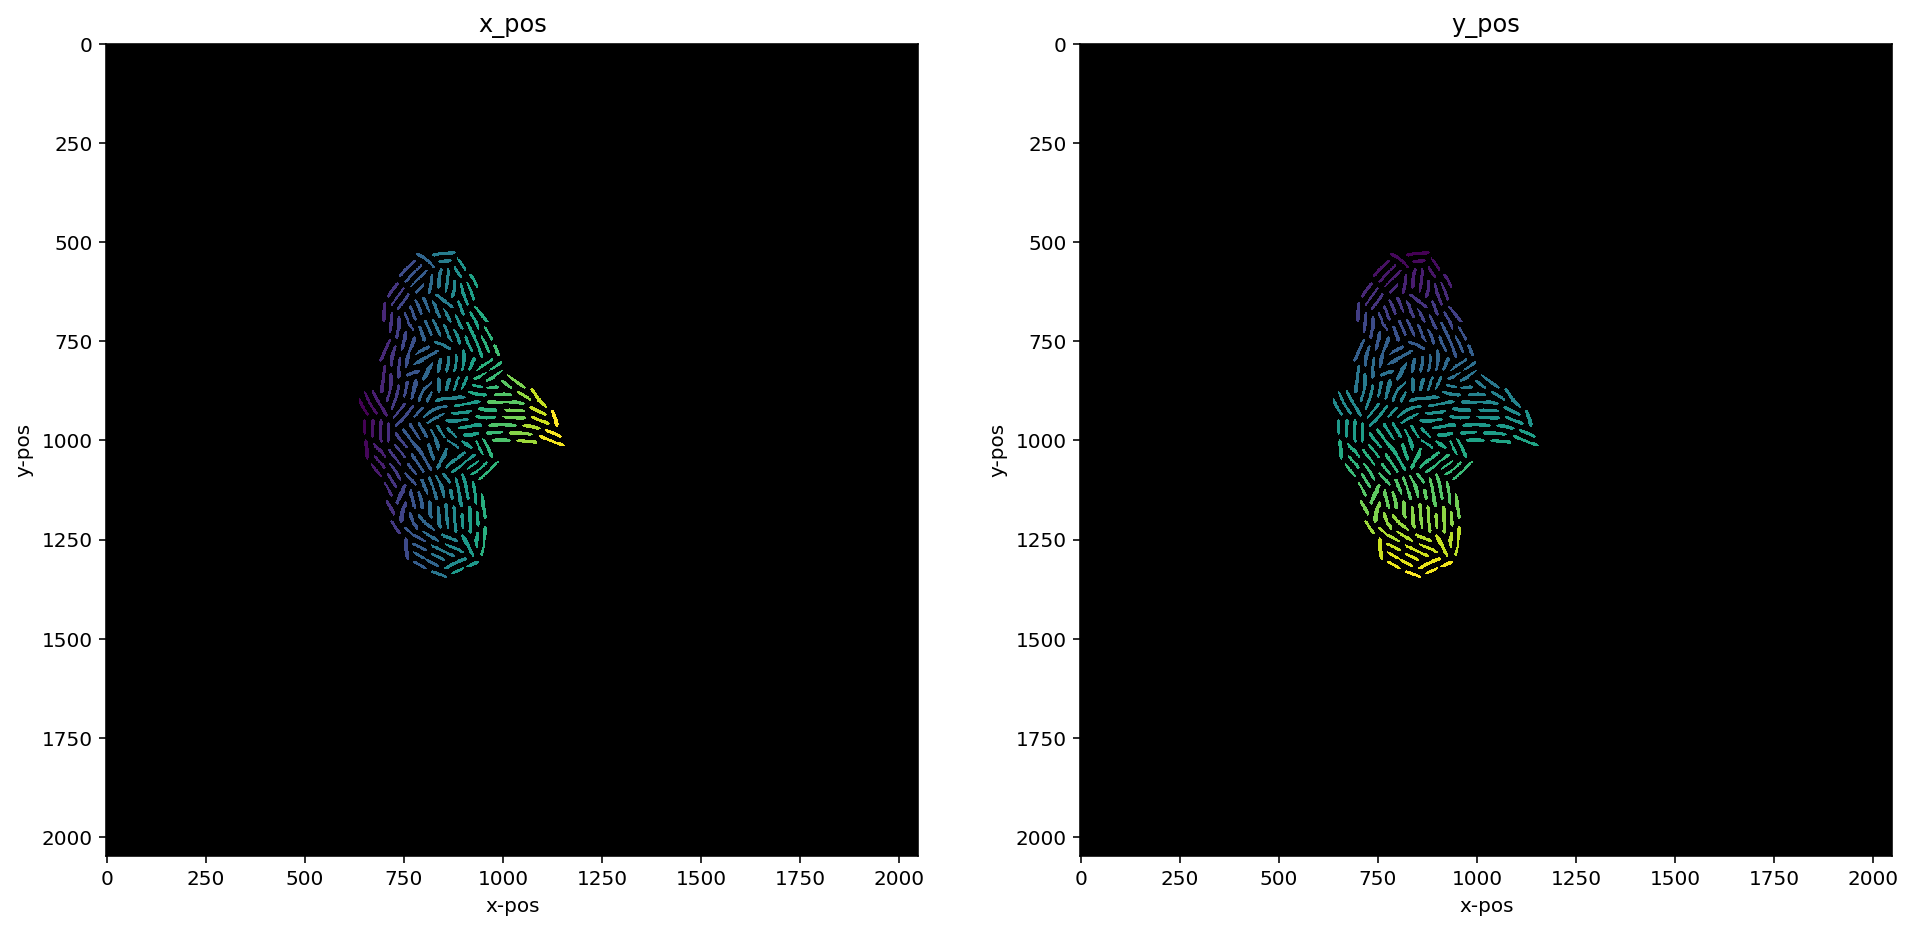

In [48]:
fig, axs = plt.subplots(1,2,figsize=(16,24))
plot_spatial_map(pos, lin, 'x_pos', axis=axs[0])
plot_spatial_map(pos, lin, 'y_pos', frame=-1, axis=axs[1])

## Add Intensity Information

Also, as you might have seen, we also still miss fluorescent intensity information and need to add this manually.
Again we provide a function to do this. 

We can then convert the list of dictonaries to a pandas data frame:

## Convert to Pandas dataframe

Now that we have all the important cell properties we can convert the Delta output to a Pandas dataframe. We provide a function for this below:

In [49]:
def lin_to_df(lin):
    #find vector based data (only vector based data is compatible with dataframe)
    vector_data = []
    [vector_data.append(key) for key in lin.cells[0].keys() if isinstance(lin.cells[0][key], list)]
    #create data frame
    df = pd.DataFrame(lin.cells) 
    #this creates nested dataframe, we need to explode time into separate rows:
    df = df.explode(vector_data)
    #and reindex
    df = df.reset_index(drop=True)

    return df

In [50]:
df = lin_to_df(lin)
df.head()

,id,mother,frames,daughters,new_pole,old_pole,edges,length,width,area,perimeter,lin_id,sublin_idx,mother_lin_id,d1_lin_id,d2_lin_id,x_pos,y_pos
0,0,NaN,0,None,"[864, 931]","[840, 930]",,46.0,14.0,565.0,25,0,0,-1,1,23,930.771104,851.672078
1,0,NaN,1,None,"[865, 920]","[838, 919]",,50.0,14.0,624.5,22,0,0,-1,1,23,919.921944,853.007364
2,0,NaN,2,None,"[870, 911]","[840, 913]",,52.163071,15.611453,688.0,28,0,0,-1,1,23,912.734584,855.462466
3,0,NaN,3,None,"[883, 897]","[843, 906]",,57.422234,15.920806,734.0,52,0,0,-1,1,23,902.762563,861.723618
4,0,NaN,4,None,"[889, 889]","[844, 899]",,61.759975,15.67858,772.0,61,0,0,-1,1,23,894.429082,866.506555


## All-in-one processing

For future use, we provide here a single wrapper function that takes as entry a delta position object and outputs a Pandas dataframe by successively calling the functions we defined above.

In [51]:
def delta_to_df(pos):
    
    lin = pos.rois[0].lineage
    
    #split lineages:
    split_lineages(lin)
    
    #add segment info
    add_segment_info(lin, pos.rois[0].label_stack)
    
    #add fluorescemt info
    
    #convert to pandas dataframe
    df = lin_to_df(lin)
   
    return df

In [52]:
df = delta_to_df(pos)
df.head()

,id,mother,frames,daughters,new_pole,old_pole,edges,length,width,area,perimeter,lin_id,sublin_idx,mother_lin_id,d1_lin_id,d2_lin_id,x_pos,y_pos
0,0,NaN,0,None,"[864, 931]","[840, 930]",,46.0,14.0,565.0,25,0,0,-1,1,23,930.771104,851.672078
1,0,NaN,1,None,"[865, 920]","[838, 919]",,50.0,14.0,624.5,22,0,0,-1,1,23,919.921944,853.007364
2,0,NaN,2,None,"[870, 911]","[840, 913]",,52.163071,15.611453,688.0,28,0,0,-1,1,23,912.734584,855.462466
3,0,NaN,3,None,"[883, 897]","[843, 906]",,57.422234,15.920806,734.0,52,0,0,-1,1,23,902.762563,861.723618
4,0,NaN,4,None,"[889, 889]","[844, 899]",,61.759975,15.67858,772.0,61,0,0,-1,1,23,894.429082,866.506555


### Saving
This would be a good time to save your data.  
You can save the position file using `pos.save(filename=filename, save_format='pickle')`. We won't do this now as we do not want to accidentally corrupt our data.

Instead we just save the dataframe:

In [56]:
save_name = processed_dir / pos_name.replace('.pkl','_df.pkl')
df.to_pickle(save_name)

And we save the updated lineage info:


In [86]:
save_name = processed_dir / pos_name.replace('.pkl','_updated_lin.pkl')
filehandler = open(save_name, 'wb') 
pickle.dump(lin, filehandler)

## Check Tracking with Napari

Now that we have the dataframe we can add the trackign info to Napari to check it visually.

For that we use the Napari [tracks layer](https://napari.org/howtos/layers/tracks.html).  
To use it we need to specify tracking data in a specific format  (see documentation above):

In [68]:
#create matrix with lin_id, and (t,x,y) coordinates
lin_data = np.vstack([df["lin_id"].to_numpy(dtype=int), 
                      df["frames"].to_numpy(dtype=int), 
                      df["y_pos"].to_numpy(dtype=int), 
                      df["x_pos"].to_numpy(dtype=int)]).T
lin_data.shape

(3495, 4)

In [69]:
#create dictionary that link lin_id of cell to lin_id of mother 
lin_id = df["lin_id"].to_numpy(dtype=int)
mom_id = df["mother_lin_id"].to_numpy(dtype=int)

#lin_id is a vector that contains many duplicate entries, we remove them using np.unique:
lin_set, idx_set = np.unique(lin_id, return_index=True)
mom_set = mom_id[idx_set]

#init graph dictionary
graph = {}
for linnum, mom in zip(lin_set, mom_set):
    if mom >= 0:
        graph[linnum] = mom

In [70]:
#add tracks to viewer
viewer.add_tracks(lin_data, name='Tracks', graph=graph)
viewer.show()